# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

**Objective:**
We have recently taken on a job to analyze a dataset containing the sale of 426,000 used cars. We want to advise our client, a used car dealership on what sort of cars are the most profitable for them to sell. We will be analyzing factos such as title status, condition of the vehicle, type of vehicle, model and manufacturer. Our goal is to quantify what qualities customers value in a used car so that our customer can focus on that for their inventory.

**Key Questions:**
What are the key factors that influence the prices of used cars?
How do different attributes, such as year, mileage, and condition, affect the prices of used cars?
Are there any specific manufacturers or models that command higher prices in the used car market?
How can the dealership use this information to optimize pricing and improve sales?

**Expected Outcome:**
The analysis is expected to provide insights into the factors that drive the prices of used cars and help the dealership understand consumer preferences. The recommendations derived from the analysis will enable the dealership to make informed decisions regarding pricing strategies, inventory management, and marketing efforts to attract and retain customers.

**Success Criteria:**
The project will be considered successful if it can identify and quantify the key factors that influence the prices of used cars and provide actionable recommendations to the dealership based on the analysis. We will then communicate these recommendations to the car dealership. They will then work on implementing.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
import numpy as np
import plotly.express as px
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
vehicles = pd.read_csv('data/vehicles.csv')

In [3]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
vehicles.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


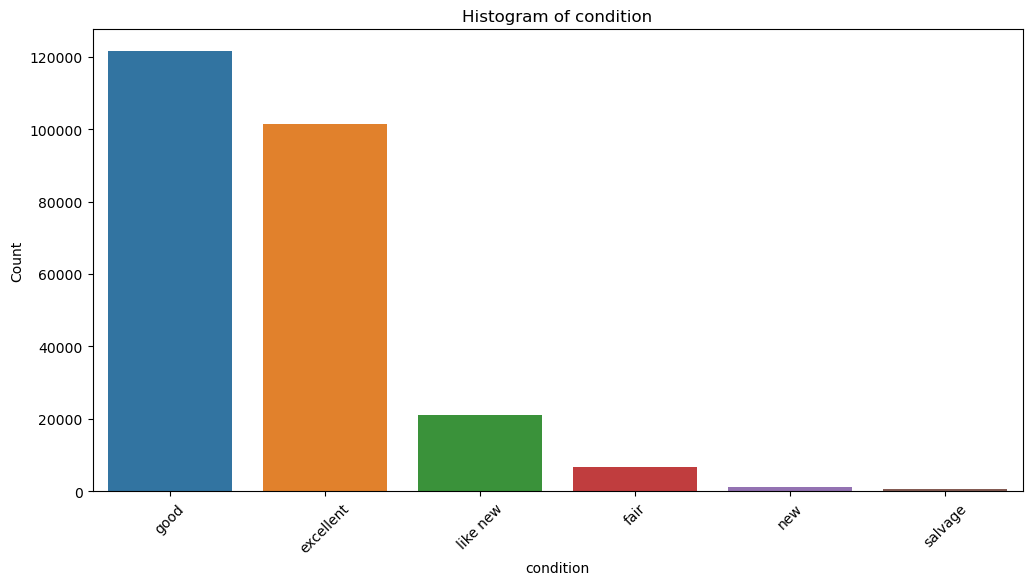

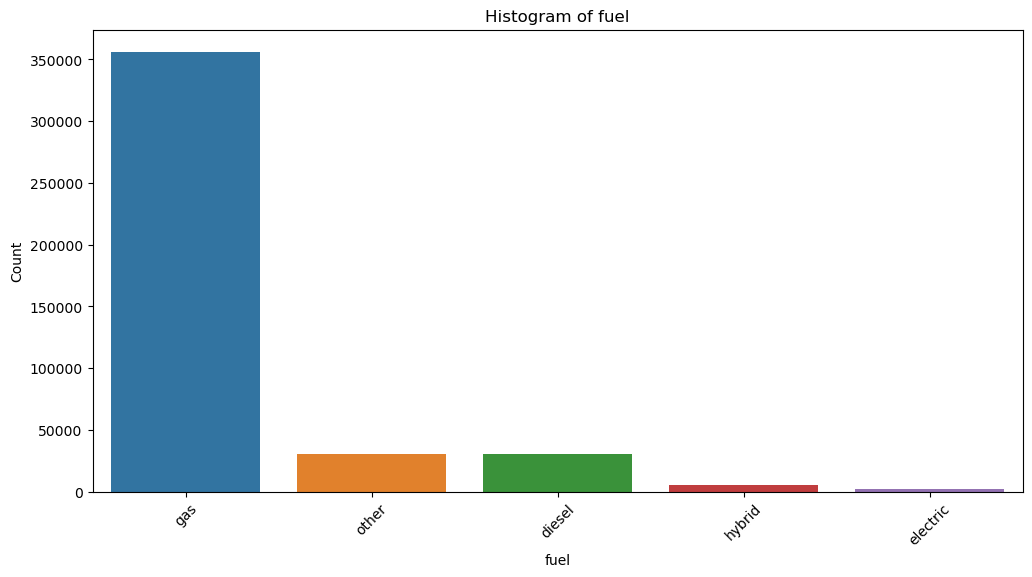

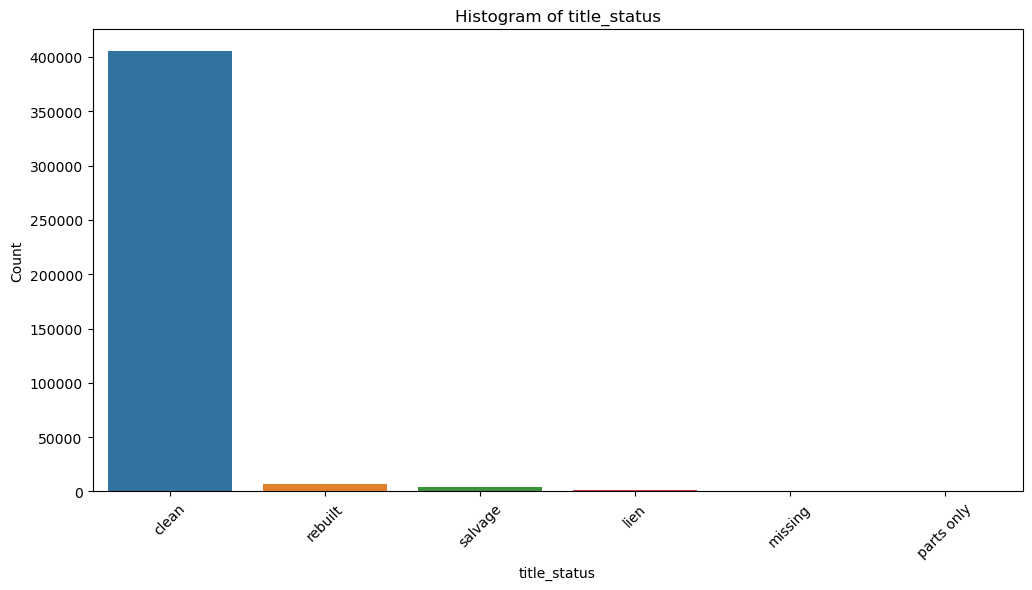

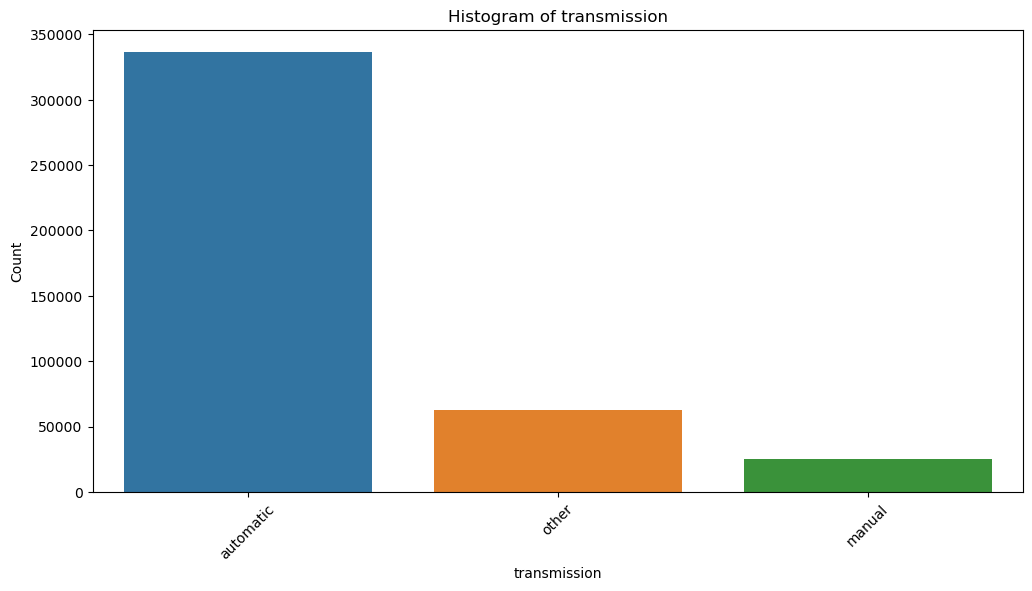

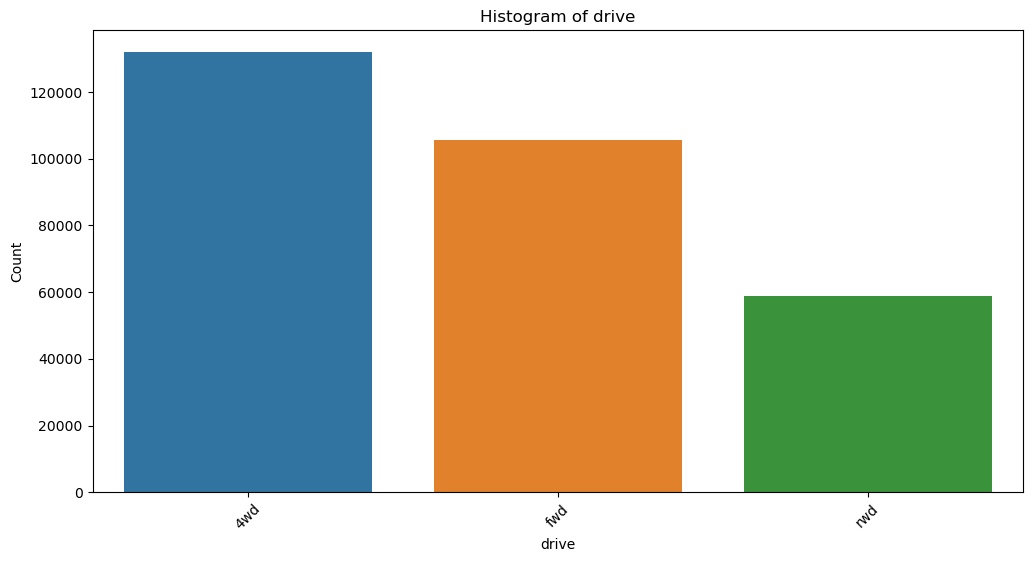

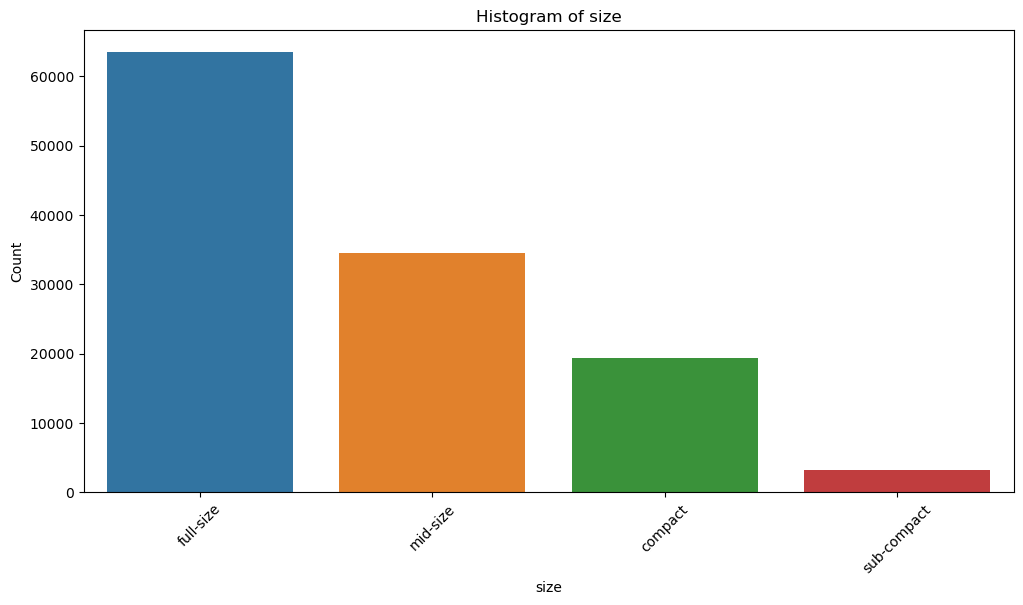

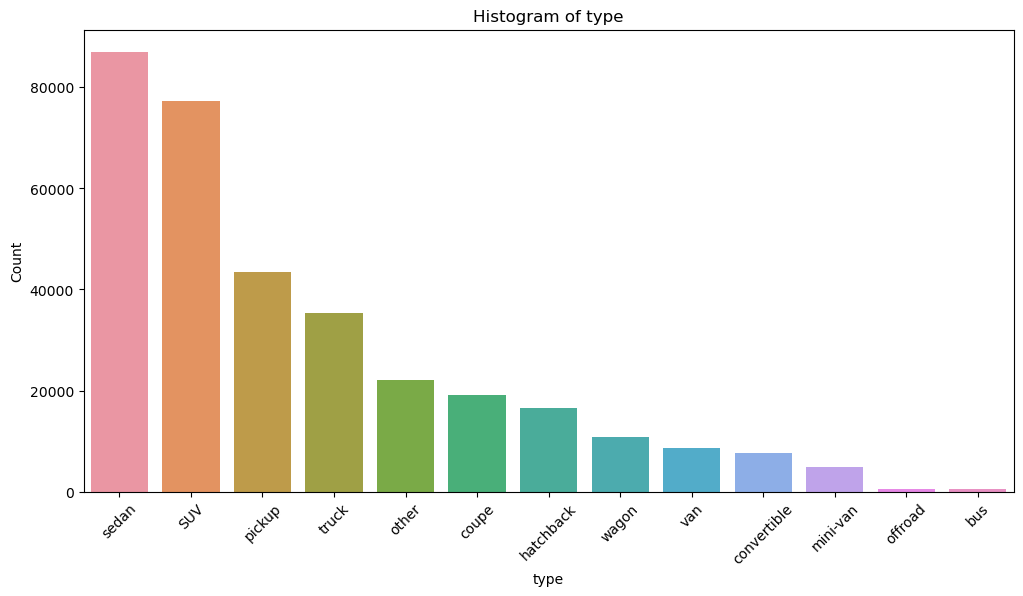

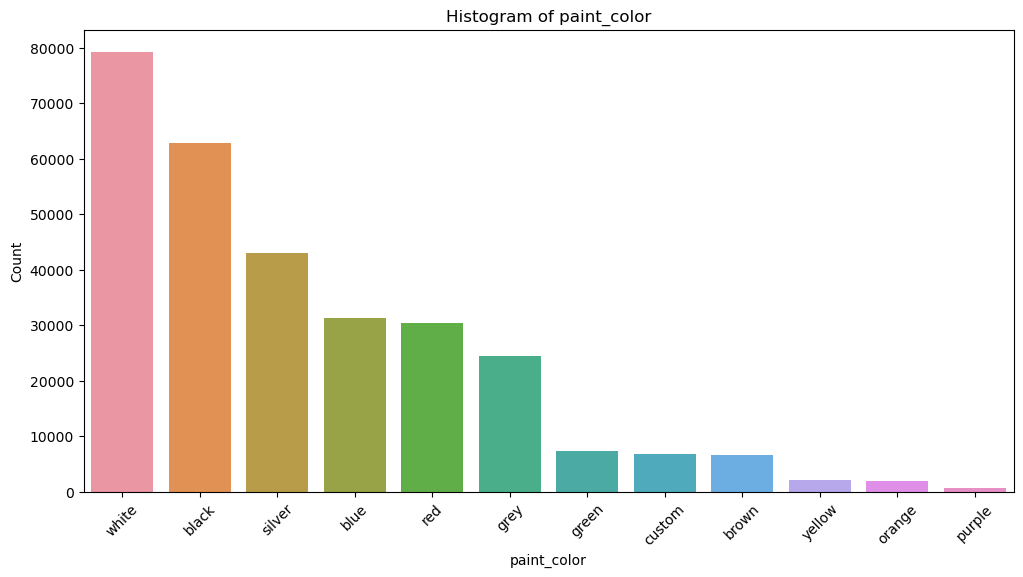

In [6]:
# Bar Plots
categorical_cols = ['condition', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=vehicles, x=col, order=vehicles[col].value_counts().index)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


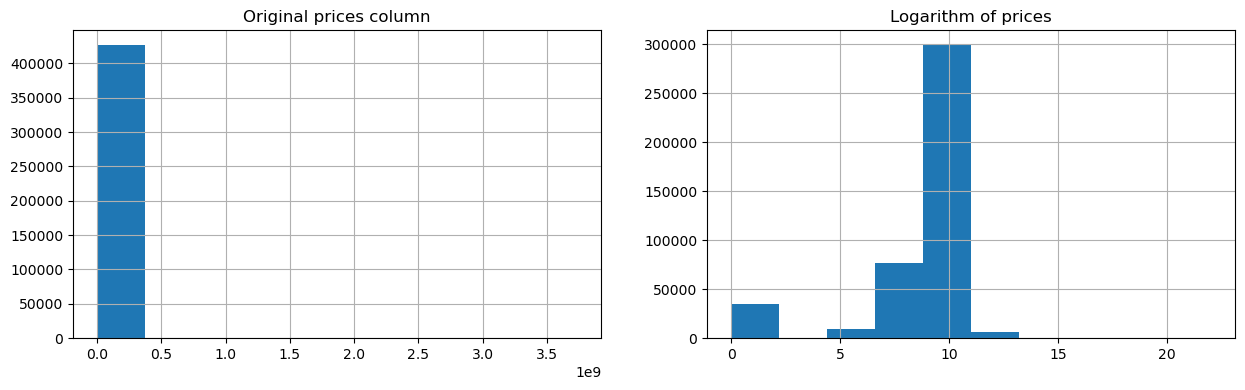

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].hist(vehicles['price'])
ax[0].grid()
ax[0].set_title('Original prices column')
ax[1].hist(np.log1p(vehicles['price']))
ax[1].grid()
ax[1].set_title('Logarithm of prices');

**Analysis of Bar graph of Original Prices Column and the Logarithm of Prices:** Taking the Logarithm of the Prices column normalize the data.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [8]:
#Checking to see how many null values each column has.
vehicles.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [9]:
#There are a lot of categorical columns with null values. Filling NULL values with the most common value for each column
vehicles['manufacturer'] = vehicles['manufacturer'].fillna(vehicles['manufacturer'].mode()[0])
vehicles['model'] = vehicles['model'].fillna(vehicles['model'].mode()[0])
vehicles['fuel'] = vehicles['fuel'].fillna(vehicles['fuel'].mode()[0])
vehicles['transmission'] = vehicles['transmission'].fillna(vehicles['transmission'].mode()[0])
vehicles['drive'] = vehicles['drive'].fillna(vehicles['drive'].mode()[0])
vehicles['size'] = vehicles['size'].fillna(vehicles['size'].mode()[0])
vehicles['type'] = vehicles['type'].fillna(vehicles['type'].mode()[0])
vehicles['paint_color'] = vehicles['paint_color'].fillna(vehicles['paint_color'].mode()[0])

In [10]:
# VIN and ID are not important  so I am just dropping it. I am also dropping region since state is also present and felt that was more useful.
df = vehicles.drop(columns=['VIN', 'id', 'region'])

In [11]:
# Extract the number of cylinders and converting to numeric data type
df['cylinders'] = df['cylinders'].str.extract('(\d+)').astype(float)

# Fill NaN values with 1. Not using 0 because I want to take the log value
df['cylinders'] = df['cylinders'].fillna(1)

In [12]:
#Handling null values
#Getting the median for year and odometer
#These are numeric fields
df['year'] = df['year'].fillna(df['year'].median())
df['odometer'] = df['odometer'].fillna(df['odometer'].median())

In [13]:
#Removing outlier Price data
df = df[df['price'] > 1000]
df = df[df['price'] < 300000]

In [14]:
# Define mapping of condition to numeric scale.
condition_map = {
    'salvage': 1,
    'fair': 2,
    'good': 3,
    'like new': 4,
    'excellent': 5,
    'new': 6
}

df['condition'] = df['condition'].fillna(df['condition'].mode()[0])

# Map condition to numeric scale
df['condition'] = df['condition'].map(condition_map).astype(float)

In [15]:
# Define mapping of title_status to numeric scale
title_status_map = {
    'missing': 1,
    'parts only': 2,
    'salvage': 3,
    'lien': 4,
    'rebuilt': 5,
    'clean': 6
}

df['title_status'] = df['title_status'].fillna(df['title_status'].mode()[0])

# Map title_status to numeric scale
df['title_status'] = df['title_status'].map(title_status_map).astype(float)

In [16]:
numerical_cols = ['year', 'odometer','cylinders','title_status','condition'] #Includes the categorical columns that I turned into numeric
categorical_cols = ['manufacturer', 'model',  'fuel', 'transmission', 'drive', 'type', 'paint_color', 'size','state']

In [17]:
#dropping duplicates
df = df.drop_duplicates()

In [18]:
df.dtypes

price             int64
year            float64
manufacturer     object
model            object
condition       float64
cylinders       float64
fuel             object
odometer        float64
title_status    float64
transmission     object
drive            object
size             object
type             object
paint_color      object
state            object
dtype: object

In [19]:
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,6000,2013.0,ford,f-150,3.0,1.0,gas,85548.0,6.0,automatic,4wd,full-size,sedan,white,az
1,11900,2013.0,ford,f-150,3.0,1.0,gas,85548.0,6.0,automatic,4wd,full-size,sedan,white,ar
2,21000,2013.0,ford,f-150,3.0,1.0,gas,85548.0,6.0,automatic,4wd,full-size,sedan,white,fl
3,1500,2013.0,ford,f-150,3.0,1.0,gas,85548.0,6.0,automatic,4wd,full-size,sedan,white,ma
4,4900,2013.0,ford,f-150,3.0,1.0,gas,85548.0,6.0,automatic,4wd,full-size,sedan,white,nc


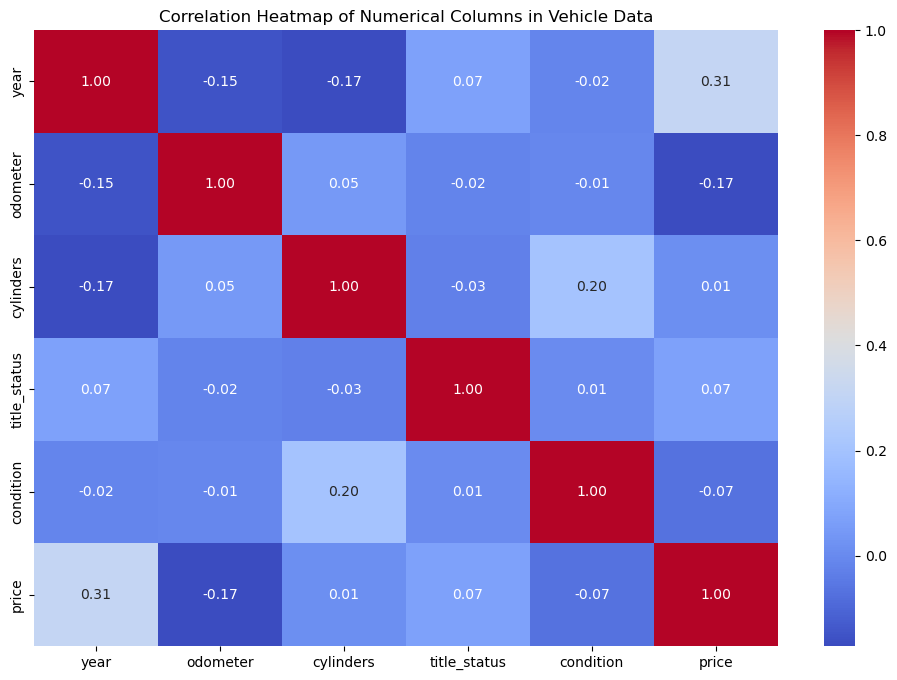

In [20]:
# Calculate the correlation matrix
corr_cols = ['year', 'odometer','cylinders','title_status','condition', 'price']
corr_matrix = df[corr_cols].corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Columns in Vehicle Data')
plt.show()

**Analysis of HeatMap of Numerical Values:** By looking at just the numerical columns of the dataset, my initial observations are that Year has a positive correlation with price- the newer the car, the more it costs. Title Status also has an impact. People do not want a car that does not have a clean title status. Odometer has a negative correlation meaning that people want a car that does not have as many miles on it. Interestingly, condition has a slightly negative correlation. 

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Model #1: Linear Regression Model

In [51]:
# Split the dataset into features (X) and target variable (y)
X = df.drop('price', axis=1)
y = np.log1p(df['price'])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [53]:
# Creating the Preprocessor that will be used for all of the models. 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # for numerical columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # for categorical columns
    ],
    remainder='passthrough',  # pass through any columns not specified
    verbose_feature_names_out=False
)


In [54]:

model_lr = make_pipeline(
    preprocessor,
    LinearRegression()

)

In [55]:

# Define the parameter grid to search(Not needed for Linear Regression)
param_grid = {
    }

# Create GridSearchCV object
grid_search = GridSearchCV(model_lr, param_grid, cv=5, n_jobs=-1)

# Perform grid search on your data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Use the best model for prediction
best_model_lr = grid_search.best_estimator_
y_pred = best_model_lr.predict(X_test)

In [29]:
model_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['year', 'odometer',
                                                   'cylinders', 'title_status',
                                                   'condition']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['manufacturer', 'model',
                                                   'fuel', 'transmission',
                                                   'drive', 'type',
                                                   'paint_color', 'size',
                                                   'state'])],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [56]:

mae_train = median_absolute_error(y_train, best_model_lr.predict(X_train))
y_pred = best_model_lr.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $",
    "MedAE on testing set": f"{mae_test:.2f} $",
}

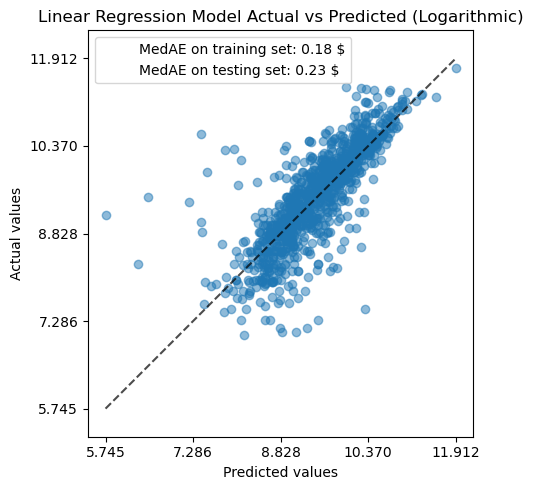

In [57]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Linear Regression Model Actual vs Predicted (Logarithmic)")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()
plt.savefig("images/LinearRegressionActualvsPredictedLog.jpg")

**Analysis of Linear Regression Model Actual vs Predicted (Logarithmic):** This graph is fairly decent with low Median Absolute Errors. The points are al very close to the line

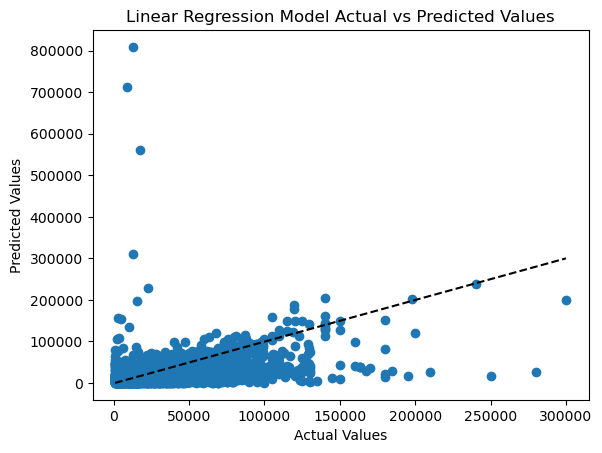

In [58]:
#Removing the log of prices column and plotting
X_test['actual'] = y_test
X_test['pred'] = y_pred
X_test['diff'] = y_test - y_pred
plt.scatter(np.expm1(X_test['actual']), np.expm1(X_test['pred']))
plt.plot([np.expm1(y.min()), np.expm1(y.max())], [(y.min()), np.expm1(y.max())], color='black', linestyle='--', label='Perfect Prediction')
plt.title("Linear Regression Model Actual vs Predicted Values")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.savefig("images/LinearRegressionActualvsPredicted.jpg")

**Analysis of Linear Regression Model Actual vs Predicted Values:** There are a few outliers but overall the plot is very close to the line. 

In [59]:
r2_linear = r2_score(y_test,y_pred)
print(r2_linear)


0.5927136901847081


In [60]:
#Doing Cross Validation
scores = cross_val_score(best_model_lr, X, y, cv=5)  # cv=5 for 5-fold cross-validation

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Calculate the mean cross-validation score
mean_score = scores.mean()
print("Mean cross-validation score:", mean_score)

Cross-validation scores: [ 0.51426769  0.58606485 -0.69227046 -1.04441945  0.59713548]
Mean cross-validation score: -0.007844379450020433


In [61]:

# Assuming 'model' is your trained model and 'X_test' is your test data
result = permutation_importance(best_model_lr, X_test, y_test, n_repeats=10, random_state=42)

# Get the permutation importance scores
importances = result.importances_mean

# Get the feature names
feature_names = X_test.columns

# Create a DataFrame to display the feature importances
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values('Importance', ascending=False)

# Display the permutation importances
print(importances_df)

         Feature  Importance
2          model    1.080341
1   manufacturer    0.796150
0           year    0.562406
6       odometer    0.017004
13         state    0.016307
3      condition    0.015315
5           fuel    0.011033
11          type    0.006453
7   title_status    0.004049
8   transmission    0.003989
4      cylinders    0.003150
12   paint_color    0.002807
10          size    0.000657
14        actual    0.000000
15          pred    0.000000
16          diff    0.000000
9          drive   -0.000242


In [62]:

# Evaluate the model
mae_linear = median_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae_linear}")

Mean Absolute Error: 0.23126517223183374


In [63]:
feature_names = best_model_lr[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    best_model_lr[-1].coef_,
    columns=["Coefficients"],
    index=feature_names,
)
# Sort coefficients by absolute values
coefs_sorted = coefs.reindex(coefs['Coefficients'].abs().sort_values(ascending=False).index)

# Print top 10
print("Top 10 coefficients:")
print(coefs_sorted.head(10))

# Print bottom 10
print("\nBottom 10 coefficients:")
print(coefs_sorted.tail(10))

Top 10 coefficients:
                              Coefficients
model_"t"                         8.685132
model_34 Tudor                    7.187155
model_1939 international          6.972778
model_International 1.5 ton       6.546305
model_2 dr victoria               6.401055
model_chevelle malibu conver      6.357821
model_Crosley wagon               6.303269
model_vickey copy                 6.040562
model_cadvwrambuick               5.608189
model_chieften                    5.561839

Bottom 10 coefficients:
                              Coefficients
state_ia                          0.000133
model_sport hse lux              -0.000133
model_645ci convertible          -0.000123
model_civic ls                   -0.000101
model_600 es                      0.000088
fuel_other                        0.000073
model_civic lx 2d coupe           0.000073
model_benz s600                  -0.000067
model_escalade premium 4wd        0.000061
model_2009 F-250 6.4L w Plow      0.000020


In [64]:
non_model_coefs = coefs[~coefs.index.str.contains('model_')]

# Sort the absolute values of coefficients in descending order
non_model_coefs_sorted = non_model_coefs['Coefficients'].abs().sort_values(ascending=False)

# Print top 10
print("Top 10 coefficients:")
print(non_model_coefs_sorted.head(10))
print("\nBottom 10 coefficients:")
print(non_model_coefs_sorted.tail(10))

Top 10 coefficients:
manufacturer_morgan          2.138125
manufacturer_ferrari         1.644090
manufacturer_aston-martin    1.291068
manufacturer_pontiac         1.091227
manufacturer_kia             1.024385
manufacturer_fiat            1.015735
manufacturer_saturn          0.973383
manufacturer_honda           0.966525
manufacturer_nissan          0.893497
manufacturer_tesla           0.868061
Name: Coefficients, dtype: float64

Bottom 10 coefficients:
state_ky           0.006226
state_vt           0.005720
type_truck         0.004208
paint_color_red    0.003446
state_la           0.003066
type_coupe         0.003008
fuel_electric      0.001323
size_compact       0.000188
state_ia           0.000133
fuel_other         0.000073
Name: Coefficients, dtype: float64


**Analysis of Results from Linear Regression Model:** The Linear Regression model is saying that the model of the car is the most important factor in the price. 

### Model 2: Random Forest Regressor

In [65]:
# Split the dataset into features (X) and target variable (y)
X = df.drop('price', axis=1)
y = np.log1p(df['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [66]:

from sklearn.ensemble import RandomForestRegressor

model_random = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=10, random_state=42)
)


In [67]:
model_random.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['year', 'odometer',
                                                   'cylinders', 'title_status',
                                                   'condition']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['manufacturer', 'model',
                                                   'fuel', 'transmission',
                                                   'drive', 'type',
                                                   'paint_color', 'size',
                                                   'state'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=10, random_state=42))])

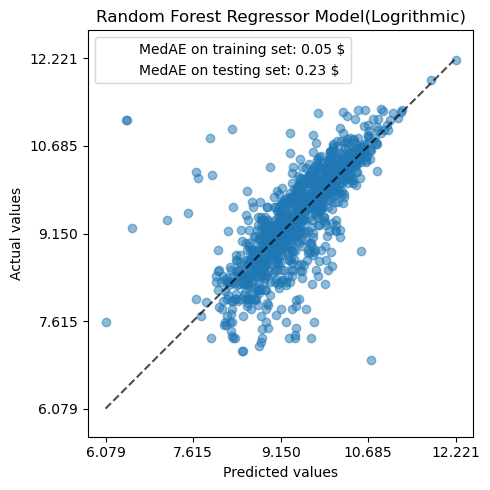

In [68]:
mae_train = median_absolute_error(y_train, model_random.predict(X_train))

mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $",
    "MedAE on testing set": f"{mae_test:.2f} $",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Random Forest Regressor Model(Logrithmic)")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.savefig("images/randomforestlogregressor.jpg")
plt.tight_layout()

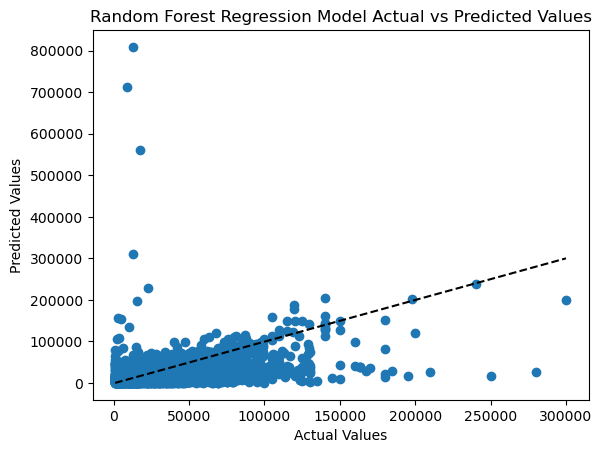

In [69]:
X_test['actual'] = y_test
X_test['pred'] = y_pred
X_test['diff'] = y_test - y_pred
plt.scatter(np.expm1(X_test['actual']), np.expm1(X_test['pred']))
plt.plot([np.expm1(y.min()), np.expm1(y.max())], [(y.min()), np.expm1(y.max())], color='black', linestyle='--', label='Perfect Prediction')
plt.title("Random Forest Regression Model Actual vs Predicted Values")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.savefig("images/RandomFRegressionActualvsPredicted.jpg")

In [ ]:
# Assuming 'model' is your trained model
scores = cross_val_score(model_random, X, y, cv=5)  # cv=5 for 5-fold cross-validation

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Calculate the mean cross-validation score
mean_score = scores.mean()
print("Mean cross-validation score for Random Forest Regression Model:", mean_score)

In [71]:
# Evaluate the model
mae_random = median_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae_random}")

Mean Absolute Error: 0.23126517223183374


In [72]:
r2_random = r2_score(y_test,y_pred)
print(r2_random)

0.5927136901847081


In [73]:

result = permutation_importance(model_random, X_test, y_test, n_repeats=10, random_state=42)

# Get the permutation importance scores
importances = result.importances_mean

# Get the feature names
feature_names = X_test.columns

# Create a DataFrame to display the feature importances
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values('Importance', ascending=False)

# Display the permutation importances
print(importances_df)

         Feature  Importance
0           year    0.672754
6       odometer    0.250265
4      cylinders    0.115815
5           fuel    0.103206
1   manufacturer    0.069559
9          drive    0.069097
11          type    0.066723
3      condition    0.040628
2          model    0.035963
7   title_status    0.011456
13         state    0.009049
8   transmission    0.008949
10          size    0.003885
12   paint_color    0.002829
14        actual    0.000000
15          pred    0.000000
16          diff    0.000000


### Model 3: Ridge Model

In [27]:
# Split the dataset into features (X) and target variable (y)
X = df.drop('price', axis=1)
y = np.log1p(df['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [28]:
from sklearn.linear_model import Ridge

model_ridge = make_pipeline(
    preprocessor,
    Ridge()
)

In [29]:
param_grid = {
    'ridge__alpha': [0.1, 1.0, 10.0],
    'ridge__solver': ['auto']
}

# Create GridSearchCV object
grid_search_ridge = GridSearchCV(model_ridge, param_grid, cv=5, n_jobs=-1)

# Perform grid search on your data
grid_search_ridge.fit(X_train, y_train)

# Get the best parameters and best score
best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = grid_search_ridge.best_score_

# Use the best model for prediction
best_model_ridge = grid_search_ridge.best_estimator_
y_pred = best_model_ridge.predict(X_test)

In [30]:
print("The alpha value and solver for Ridge Model is",best_params_ridge)

The alpha value and solver for Ridge Model is {'ridge__alpha': 1.0, 'ridge__solver': 'auto'}


In [31]:
print("The best score for Ridge Model is: ", best_score_ridge)

The best score for Ridge Model is:  0.6050568975778232


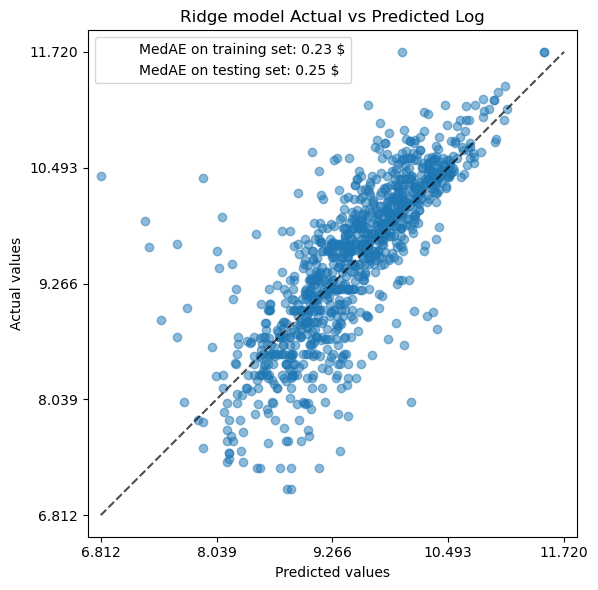

In [32]:
mae_train = median_absolute_error(y_train, best_model_ridge.predict(X_train))

mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $",
    "MedAE on testing set": f"{mae_test:.2f} $",
}

_, ax = plt.subplots(figsize=(6, 6))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model Actual vs Predicted Log")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()
plt.savefig("images/RidgeRegressionActualvsPredictedLog.jpg")

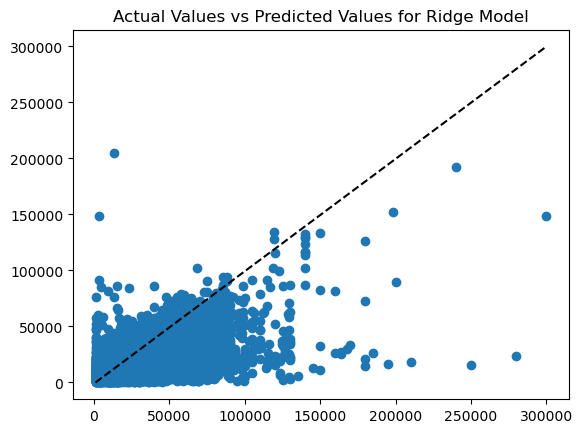

In [33]:
X_test['actual'] = y_test
X_test['pred'] = y_pred
X_test['diff'] = y_test - y_pred
plt.scatter(np.expm1(X_test['actual']), np.expm1(X_test['pred']))
plt.title("Actual Values vs Predicted Values for Ridge Model")
plt.plot([np.expm1(y.min()), np.expm1(y.max())], [(y.min()), np.expm1(y.max())], color='black', linestyle='--', label='Perfect Prediction')
plt.savefig("images/RidgeActualvsPredicted.jpg")

In [34]:
#Cross Validation of Ridge Model
scores = cross_val_score(best_model_ridge, X, y, cv=5)  # cv=5 for 5-fold cross-validation

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Calculate the mean cross-validation score
mean_score = scores.mean()
print("Mean cross-validation score:", mean_score)

Cross-validation scores: [0.55114664 0.58929594 0.32222788 0.14163382 0.61086624]
Mean cross-validation score: 0.443034104728821


In [35]:
#R2 or Ridge Model
r2_ridge = r2_score(y_test,y_pred)
print(r2_ridge)

0.6088844303731096


In [36]:
# Evaluate the model
mae_ridge = median_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae_ridge}")

Mean Absolute Error: 0.251687496559275


In [37]:

result = permutation_importance(best_model_ridge, X_test, y_test, n_repeats=10, random_state=42)

# Get the permutation importance scores
importances = result.importances_mean

# Get the feature names
feature_names = X_test.columns

# Create a DataFrame to display the feature importances
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values('Importance', ascending=False)

# Display the permutation importances
print(importances_df)

         Feature  Importance
2          model    0.527285
0           year    0.389856
1   manufacturer    0.176465
13         state    0.018286
6       odometer    0.017919
5           fuel    0.017910
3      condition    0.015548
11          type    0.013257
8   transmission    0.008132
7   title_status    0.003980
12   paint_color    0.003432
4      cylinders    0.003419
10          size    0.001384
9          drive    0.000492
14        actual    0.000000
15          pred    0.000000
16          diff    0.000000


In [39]:
feature_names = best_model_ridge[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    best_model_ridge[-1].coef_,
    columns=["Coefficients"],
    index=feature_names,
)
# Sort coefficients by absolute values
coefs_sorted = coefs.reindex(coefs['Coefficients'].abs().sort_values(ascending=False).index)

# Print top 10
print("Top 10 coefficients:")
print(coefs_sorted.head(10))

# Print bottom 10
print("\nBottom 10 coefficients:")
print(coefs_sorted.tail(10))

Top 10 coefficients:
                              Coefficients
model_"t"                         3.787512
model_willys coupe                3.234585
model_nomad                       3.200469
model_34 Tudor                    3.148803
model_chevelle malibu conver      3.069392
model_1939 international          3.054132
model_coe                         3.051820
model_model a                     3.011241
model_t bucket                    2.930703
model_tudor                       2.909050

Bottom 10 coefficients:
                                           Coefficients
model_santa fe sport 2.4lsuv                  -0.000237
model_a4 2.0t quattro premium +               -0.000228
model_juke nismo rs                           -0.000212
model_sierra 1500 4wd ext cab 143.5" sle1      0.000195
model_bens s550                               -0.000173
model_540i sport                              -0.000135
model_colorado 4x4                             0.000123
model_ls 460 luxury sedan        

### Model 4: Lasso Model

In [75]:
# Split the dataset into features (X) and target variable (y)
X = df.drop('price', axis=1)
y = np.log1p(df['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [76]:
from sklearn.linear_model import Lasso

model_lasso = make_pipeline(
    preprocessor,
    Lasso()
)

In [77]:
param_grid = {
    'lasso__alpha': [0.1, 1.0, 10.0],
    'lasso__tol': [0.0001, 0.001, 0.01]
}

# Create GridSearchCV object
grid_search_lasso = GridSearchCV(model_lasso, param_grid, cv=5, n_jobs=-1)

# Perform grid search on your data
grid_search_lasso.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search_lasso.best_params_
best_score = grid_search_lasso.best_score_

# Use the best model for prediction
best_model_lasso = grid_search_lasso.best_estimator_
y_pred = best_model_lasso.predict(X_test)

In [78]:
print("The alpha value and solver for Lasso Model is",best_params)

The alpha value and solver for Lasso Model is {'lasso__alpha': 0.1, 'lasso__tol': 0.001}


In [79]:
print("The best score for lasso Model is: ", best_score)

The best score for lasso Model is:  0.14774206578035698


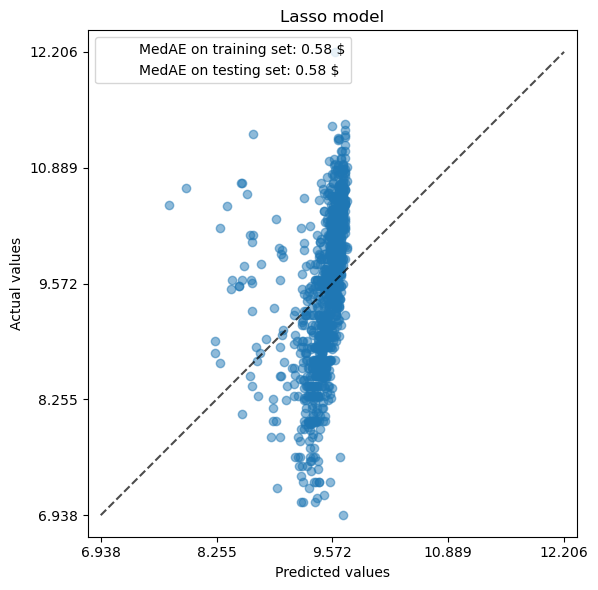

In [80]:
mae_train = median_absolute_error(y_train, best_model_lasso.predict(X_train))

mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $",
    "MedAE on testing set": f"{mae_test:.2f} $",
}

_, ax = plt.subplots(figsize=(6, 6))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Lasso model")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()
plt.savefig("images/LassoRegressionActualvsPredictedLog.jpg")

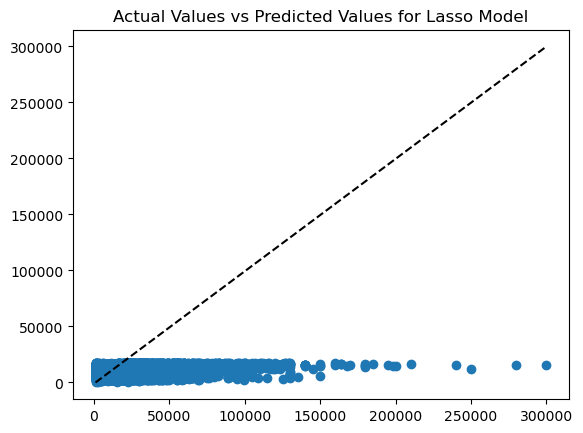

In [81]:
X_test['actual'] = y_test
X_test['pred'] = y_pred
X_test['diff'] = y_test - y_pred
plt.scatter(np.expm1(X_test['actual']), np.expm1(X_test['pred']))
plt.title("Actual Values vs Predicted Values for Lasso Model")
plt.plot([np.expm1(y.min()), np.expm1(y.max())], [(y.min()), np.expm1(y.max())], color='black', linestyle='--', label='Perfect Prediction')
plt.savefig("images/LassoActualvsPredicted.jpg")

In [82]:

result = permutation_importance(best_model_lasso, X_test, y_test, n_repeats=10, random_state=42)

# Get the permutation importance scores
importances = result.importances_mean

# Get the feature names
feature_names = X_test.columns

# Create a DataFrame to display the feature importances
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values('Importance', ascending=False)

# Display the permutation importances
print(importances_df)

         Feature  Importance
0           year    0.201229
6       odometer    0.013271
9          drive    0.000000
15          pred    0.000000
14        actual    0.000000
13         state    0.000000
12   paint_color    0.000000
11          type    0.000000
10          size    0.000000
8   transmission    0.000000
1   manufacturer    0.000000
7   title_status    0.000000
5           fuel    0.000000
4      cylinders    0.000000
3      condition    0.000000
2          model    0.000000
16          diff    0.000000


In [83]:
# Evaluate the model
mae_lasso = median_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae_lasso}")

Mean Absolute Error: 0.5754515528221749


In [84]:
#R2 or Ridge Model
r2_lasso = r2_score(y_test,y_pred)
print(r2_lasso)

0.14289612719214395


In [85]:
feature_names = best_model_lasso[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    best_model_lasso[-1].coef_,
    columns=["Coefficients"],
    index=feature_names,
)
# Sort coefficients by absolute values
coefs_sorted = coefs.reindex(coefs['Coefficients'].abs().sort_values(ascending=False).index)

# Print top 10
print("Top 10 coefficients:")
print(coefs_sorted.head(10))

# Print bottom 10
print("\nBottom 10 coefficients:")
print(coefs_sorted.tail(10))

Top 10 coefficients:
                                   Coefficients
year                                   0.227938
odometer                              -0.037014
state_wv                               0.000000
model_mci bus                          0.000000
model_mdx sh awd avance               -0.000000
model_mdx sh awd 4dr suv              -0.000000
model_mdx sh awd                       0.000000
model_mdx basesuv                      0.000000
model_mdx awd tech pkg nav 1owner     -0.000000
model_mdx awd tech pkg                -0.000000

Bottom 10 coefficients:
                                    Coefficients
model_challenger r/t                         0.0
model_challenger r/t plus 345 hemi           0.0
model_challenger r/t plus 2dr                0.0
model_challenger r/t plus                    0.0
model_challenger r/t coupe 2d                0.0
model_challenger r/t coupe                   0.0
model_challenger r/t classic                 0.0
model_challenger r/t 392 coupe    

In [87]:
#Cross Validation of Ridge Model
scores = cross_val_score(best_model_lasso, X, y, cv=5)  # cv=5 for 5-fold cross-validation

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Calculate the mean cross-validation score
mean_score = scores.mean()
print("Mean cross-validation score:", mean_score)

Cross-validation scores: [0.14202142 0.14600743 0.14709636 0.12214323 0.14894192]
Mean cross-validation score: 0.14124207225902347


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [92]:
results_df = pd.DataFrame(columns=['Model', 'R2', 'MAE'])
results_df.loc[0] = [ 'Linear' ,  r2_linear,  mae_linear ]
results_df.loc[1] = [ 'Random Forest' ,  r2_random,  mae_random]
results_df.loc[2] = [ 'Ridge Regression' ,  r2_ridge,  mae_ridge]
results_df.loc[3] = [ 'Lasso Regression' ,  r2_lasso,  mae_lasso]

In [93]:
results_df

,Model,R2,MAE
0,Linear,0.592714,0.231265
1,Random Forest,0.592714,0.231265
2,Ridge Regression,0.608884,0.251687
3,Lasso Regression,0.142896,0.575452


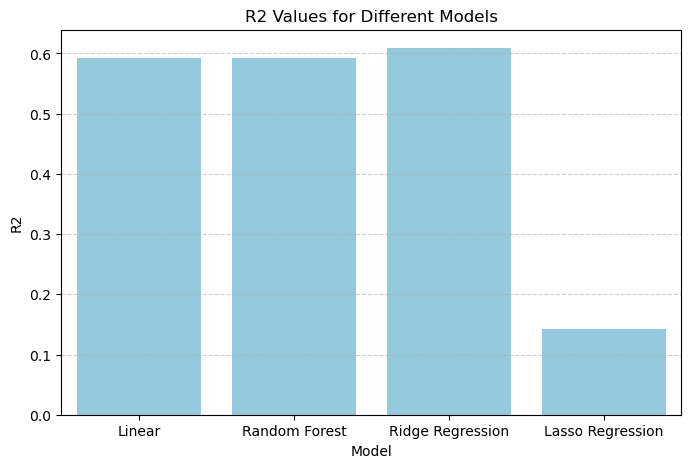

In [96]:
# Create a bar plot for R2
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='R2', data=results_df, color='skyblue')
plt.title('R2 Values for Different Models')
plt.ylabel('R2')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('images/R2metrics.jpg')
plt.show()

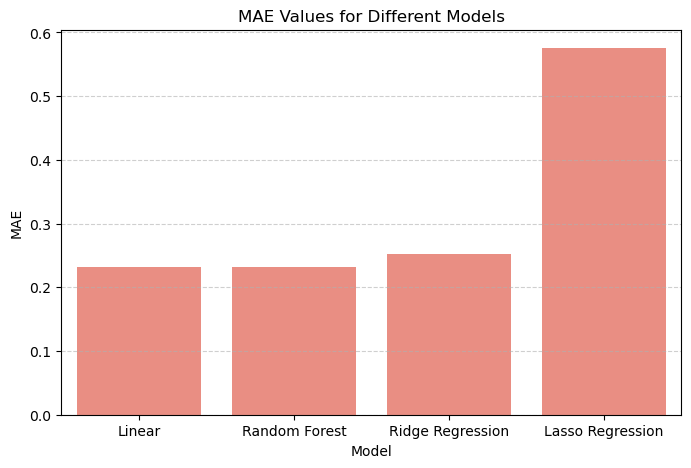

In [97]:
# Create a bar plot for MAE
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='MAE', data=results_df, color='salmon')
plt.title('MAE Values for Different Models')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('images/MAEmetrics.jpg')
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.